In [17]:
import math
import numpy as np
import itertools
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist

# Physical variables

D = 3
packfrac = 0.2

# Non-physical parameters

sidepartnum = 10

accratio = 0.3
drmax = 1

density = packfrac / (np.pi**(D/2) * (1/2)**D / math.gamma(D/2 + 1))
partnum = sidepartnum ** D
boxlen = (partnum / density)**(1/D)
conf = np.array([
    (np.array(index) + 0.5) * density**(-1/D)
    for index in itertools.product(range(sidepartnum), repeat=D)
])

# Utils

def banner():
    print(f'''
____________________________________

            Monte-Carlo
____________________________________


D = {D}
N = {partnum}
d = {density}
L = {boxlen}

''')

# Energy

def partener(n):
    rn = conf[n]
    rvec = conf - rn
    rvec = rvec[np.arange(partnum) != n]
    rvec -= boxlen * np.round(rvec / boxlen)
    r = np.linalg.norm(rvec, axis=1)

    u = np.zeros(partnum - 1)
    dl = 50
    dT = 1.4737
    mask = r <= dl / (dl - 1)
    r = r[mask]
    u[mask] = ((dl * ( dl / (dl - 1))**(dl - 1))  / dT) * ((1 / r)**dl - (1 / r)**(dl - 1)) + 1 / dT

    return np.sum(u)

def totener():
    energies = np.array([ partener(n) for n in range(partnum) ])
    return .5 * np.sum(energies)


# Motion

def boundcond():
    conf[np.any(conf > boxlen, axis=1)] %= boxlen

def movepart(n):
    v = np.random.randn(D)
    u = v / np.linalg.norm(v)
    dr = u * np.random.rand() * drmax
    conf[n] += dr
    conf[n] %= boxlen

# MonteCarlo sex

def mloglikelihood():
    pass

def mlogprior():
    pass

def adjustdr(ratio):
    global drmax
    drmax *= 1.05 if ratio > accratio else 0.95

def sampling(iterations):
    enerchain = []
    confchain = []

    energy = totener()
    accepteds = 0
    for tries in range(1, iterations + 1):
        n = np.random.randint(partnum)
        initpos = conf[n].copy()
        initener = partener(n)
        movepart(n)
        finalener = partener(n)

        diffener = finalener - initener

        if diffener < 0 or np.exp(-diffener) > np.random.rand():
            energy += diffener
            enerchain.append(energy)
            confchain.append(conf)
            accepteds += 1
            if accepteds % partnum == 1:
                enerchain.append(energy)
                confchain.append(conf.copy())
        else:
            conf[n] = initpos.copy()

        if tries % 100 == 0:
            ratio = accepteds / tries
            adjustdr(ratio)

        if tries % 1000 == 0:
            print(f'{tries}\t{energy}\t{drmax}\t{ratio}')

    return np.array(enerchain), np.array(confchain)

# Plots

def plothist(data, ax):
    counts, bins = np.histogram(data, bins=20)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    bin_width = bins[1] - bins[0]
    ax.bar(bin_centers, counts, width=bin_width, edgecolor='black')

def plot(conf, fn = None):
    D = conf.shape[1]
    fig, axs = plt.subplots(D, D, layout="constrained") 

    for i in range(D):
        for j in range(D):
            if j > i:
                axs[i, j].set_visible(False)
                
    for i in range(D):
        for j in range(D):
            if j < i:
                axs[i, j].set_title(f'Plane {i}{j}')
                axs[i, j].scatter(
                    conf[:, i],
                    conf[:, j],
                    marker='.',
                    alpha=0.5
                )
                
    for i in range(D):
        plothist(conf[:, i], axs[i, i])

    if fn == None:    
        plt.show()
    else:
        plt.savefig(fn)
        plt.show()


def plotheat(conf):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    x = conf[:, 0]
    y = conf[:, 1]
    z = conf[:, 2]
    c = conf[:, 3]

    img = ax.scatter(x, y, z, c=c, cmap=plt.hot())
    fig.colorbar(img)
    plt.show()

def estimador_gr(conf, bins=50, r_max=None, fn = None):
    N = conf.shape[0]
    d = conf.shape[1]
    
    dists = pdist(conf)
    
    if r_max is None:
        r_max = np.max(dists)

    hist, bin_edges = np.histogram(dists, bins=bins, range=(0, r_max))
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    
    #Volumen de las cáscaras esféricas en D dimensiones
    dr = bin_edges[1] - bin_edges[0]
    def volume_shell(r, dr, d):
        from scipy.special import gamma
        vol_d = (np.pi ** (d / 2)) / gamma(d / 2 + 1)
        return vol_d * ((r + dr/2) ** d - (r - dr/2) ** d)

    shell_volumes = np.array([volume_shell(r, dr, d) for r in bin_centers])
    
    #Volumen total aproximado (caja mínima que contiene las partículas)
    box_min = conf.min(axis=0)
    box_max = conf.max(axis=0)
    V = np.prod(box_max - box_min)

    rho = N / V
    
    #Estimador de g(r)
    norm_factor = rho * N  #número esperado de pares por unidad de volumen
    gr = hist / (norm_factor * shell_volumes)

    plt.plot(bin_centers, gr, c='cadetblue', lw = 2)
    plt.xlabel("r")
    plt.ylabel("g(r)")
    plt.title("Radial correlation function $g(r_{i}-r_{j})$")
    plt.grid(True)
    if fn == None:    
        plt.show()
    else:
        plt.savefig(fn)
        plt.show()

    return bin_centers, gr

# main

banner()
enerchain, confchain = sampling(100_000)


____________________________________

            Monte-Carlo
____________________________________


D = 3
N = 1000
d = 0.3819718634205489
L = 13.782337338022653


1000	11.229510753734063	1.628894626777442	0.42
2000	18.019184224465935	2.6532977051444226	0.3425
3000	20.12765487722899	3.200972114367609	0.2896666666666667
4000	15.961699954465827	1.9165402463438634	0.27525
5000	21.901737666588268	1.147503441023093	0.2864
6000	20.488783698944744	1.1332311879019652	0.31133333333333335
7000	18.603993986043214	1.8459141928701293	0.31985714285714284
8000	18.761240493666026	3.006799710258373	0.310875
9000	21.326139856069787	3.6274414316058707	0.29677777777777775
10000	25.260586576335836	2.1718831800261817	0.29
11000	29.520398233391482	1.3003866875921928	0.29
12000	29.07031814861792	0.9511301645802769	0.30141666666666667
13000	28.02841896623512	1.5492908144507571	0.3068461538461538
14000	29.4887404244283	2.5236314829744857	0.3062142857142857
15000	25.73132236067619	3.365019148055903	0.2990666666

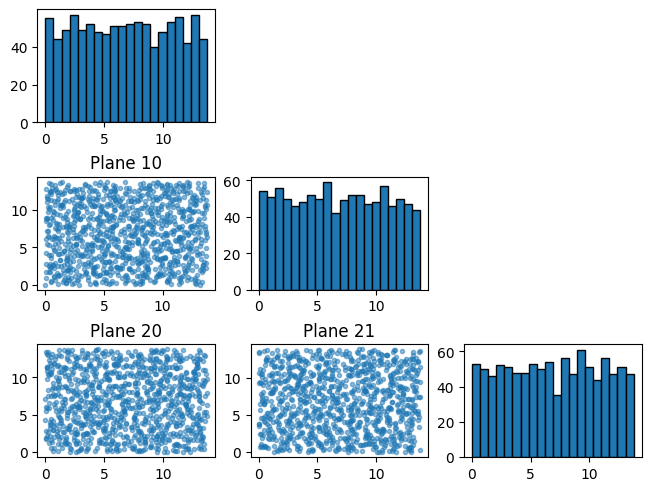

In [18]:
plot(conf)

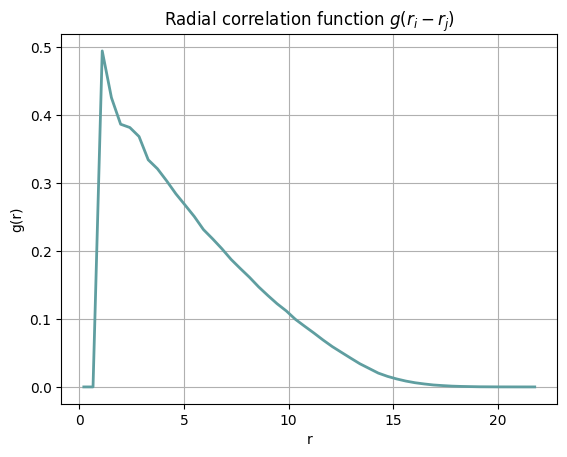

In [19]:
r, gr = estimador_gr(conf) #Estimador, devuelve distancias por bin y la función de correlación radial

# MODELADO

Esto calcula parametros del potencial PHS para ajustar su coeficiente de virial hasta concidir con el de HS

In [1]:
from scipy.integrate import quad
import math
import numpy as np
import matplotlib.pyplot as plt

In [32]:
D =  4
V = lambda r: np.pi**(D/2) * r**D / math.gamma(D/2 + 1) 
integrand = lambda r: r**(D - 1)
result, error = quad(integrand, 0, 1)
B_HS = result * np.pi**(D / 2) / math.gamma(D / 2)
print(B_HS)

def diff(dl):
    dT = 1.4737
    def u(r):
        if r > dl / (dl - 1):
            return 0
        return ((dl * ( dl / (dl - 1))**(dl - 1))  / dT) * ((1 / r)**dl - (1 / r)**(dl - 1)) + 1 / dT
    
    integrand = lambda r: (np.exp(-u(r)) - 1) * r**(D-1)
    result, error = quad(integrand, 0, dl / (dl -1 ))
    B_PHS = -result * np.pi**(D / 2) / math.gamma(D / 2)
    
    return abs(B_HS - B_PHS)

x = np.arange(60, 70, 0.1)
y = [ diff(z) for z in x ]

2.4674011002723395


In [37]:
np.pi / 12

0.2617993877991494

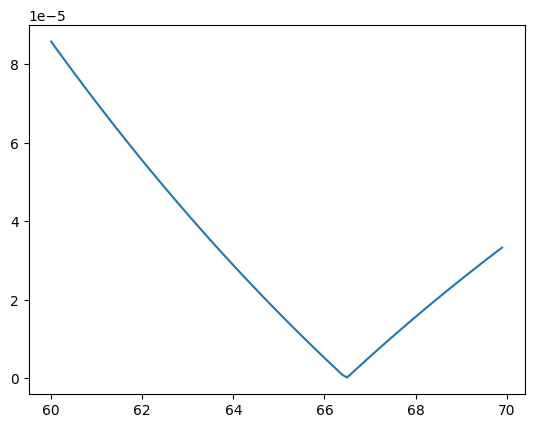

In [38]:
plt.plot(x,y)

In [39]:
4 * np.pi 

12.566370614359172

In [24]:
import emcee
import corner

  0%|                                   | 0/200000 [00:00<?, ?it/s]/home/alan/cetera/lab/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|████████████████████| 200000/200000 [01:26<00:00, 2321.60it/s]


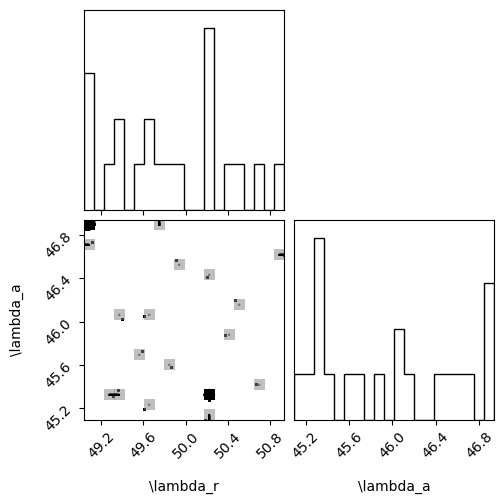

In [55]:
np.random.seed(42)
D = 3
V = lambda r: np.pi**(D/2) * r**D / math.gamma(D/2 + 1) 
integrand = lambda r: r**(D - 1)
result, error = quad(integrand, 0, 1)
B_HS = result * np.pi**(D / 2) / math.gamma(D / 2)

def log_likelihood(theta):
    r, a = theta

    T = 1.4737
    e = 1 / T

    
    A = r / (r - a) * (r / a)**(a / (r - a))
    B = (r / a)**(1 / (r - a))
        
    def u(x):
        if x >= B:
            return 0
        return A * e * ( (1/x)**r - (1/x)**a ) + e
    
    integrand = lambda r: (np.exp(-u(r)) - 1) * r**(D-1)
    result, error = quad(integrand, 0, B)
    B_PHS = -result * np.pi**(D / 2) / math.gamma(D / 2)

    chi =  np.sum(np.abs(B_HS - B_PHS))
    return -0.5 

def log_prior(theta):
    r, a = theta
    if 1 < r < 10 and 1 < a < 10:
        return 0.0 
    return -np.inf

def log_posterior(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta)

ndim = 2           
nwalkers = 20
p0 = np.random.rand(nwalkers, ndim)
p0[:, 0] = 50 + 2 * (p0[:, 0] - 0.5)  # Primer parámetro alrededor de 50
p0[:, 1] = 46 + 2 * (p0[:, 1] - 0.5)  # Segundo parámetro alrededor de 46
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)
sampler.run_mcmc(p0, 200000, progress=True)
samples = sampler.get_chain(discard=1000, flat=True)

corner.corner(samples, labels=["\lambda_r", "\lambda_a"])
plt.show()

In [30]:
def u(r):
    dl = 50
    dT = 1.4737
    if r > dl / (dl - 1):
        return 0
    return ((dl * ( dl / (dl - 1))**(dl - 1))  / dT) * ((1 / r)**dl - (1 / r)**(dl - 1)) + 1 / dT



In [31]:
f = lambda r: np.exp(-u(r)) -1 

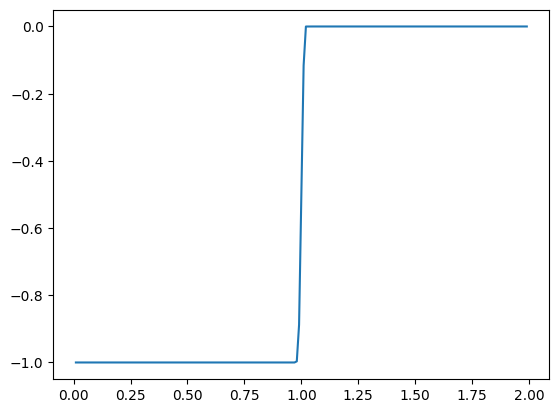

In [34]:
r = np.arange(0.01, 2, 0.01)
plt.plot(r, [f(x) for x in r])